### Libraries

In [2]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [5]:
df = pd.read_csv('C:\\Users\\UserAlba\\OneDrive - UAM\\Documentos\\GitHub\\Weather_map\\src\\data\\entities.csv')

In [6]:
df.shape

(590, 10)

In [7]:
df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster
79,How underwater drones could shape a potential ...,https://www.technologyreview.com/2024/06/20/10...,2024,How underwater drones could shape a potential ...,"['US', 'The US Department of Defense', 'CNAS',...",2,#0000ff,557.142857,753.727273,p_7
566,"The Brood X cicadas are here — and yes, there’...",https://www.technologyreview.com/2021/06/03/10...,2021,"The Brood X cicadas are here — and yes, there’...","['Michelle Watson', 'US', 'Gene Kritsky', 'the...",-1,#ff0000,297.402597,203.766234,-1
184,Google’s Gemini is now in everything. Here’s h...,https://www.technologyreview.com/2024/02/08/10...,2024,Google’s Gemini is now in everything. Here’s h...,"['US', 'Google One Premium Plan', 'Behr', 'Hsa...",2,#0000ff,525.974026,100.000000,p_10


### Clean Data

In [8]:
df.columns

Index(['title', 'url', 'year', 'text', 'entities', 'temperature', 'color', 'x',
       'y', 'cluster'],
      dtype='object')

### Lematization

In [9]:

nlp = spacy.load("en_core_web_sm")

In [11]:
df['text_clean'] = df['title'] + ' ' + df['text'] 

In [12]:
df.text[1]

'What impact will AI have on video game development?\r\nIt could make working conditions more bearable—or it could just put people out of work.\r\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\r\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\r\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits

In [13]:
words={'ai'}
# Función para limpiar el texto
def clean_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text)
    
    # Lematizar y filtrar stopwords, puntuación y palabras personalizadas
    tokens = [token.lemma_.lower() for token in doc 
              if token.text.lower() not in STOP_WORDS  # Eliminar stopwords
              and token.is_alpha  # Mantener solo caracteres alfabéticos
              and token.text.lower() not in string.punctuation  # Eliminar puntuación
              and token.text.lower() not in words]  # Eliminar palabras específicas
    
    # Unir los tokens limpios en un solo string
    return ' '.join(tokens)

In [14]:
# Aplicar la función de limpieza a la columna 'text'
df['clean_text'] = df['text_clean'].apply(clean_text)

In [15]:
df = df.drop('text_clean', axis=1)

In [16]:
df.head()

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,203.896104,421.675325,-1,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,276.623377,556.571429,-1,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,141.558442,608.454545,p_2,useful robot need lazy useful robot need lazy ...
3,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"['Marcus Holmström', 'The Gang', 'AI', 'France...",2,#0000ff,338.961039,266.025974,p_11,roblox launch generative build environment sna...
4,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\r\nIntegrating security from code to...,"['TEE', 'Microsoft Security', 'Insights', 'the...",2,#0000ff,349.350649,857.493506,-1,integrate security code cloud sponsored integr...


In [18]:
# Define helper function
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample.
    '''
    # Vectoriza el texto
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Suma de las ocurrencias de cada palabra en todos los documentos
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Obtiene los índices de las palabras ordenadas por frecuencia
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    
    # Obtiene los valores de las frecuencias
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    # Prepara los vectores de palabras más frecuentes
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Obtiene las palabras correspondientes a los índices más frecuentes
    words = [word for word in count_vectorizer.inverse_transform(word_vectors)[0]]

    return (words, word_values[0,:n_top_words].tolist()[0])


In [19]:
count_vectorizer = CountVectorizer()

In [21]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

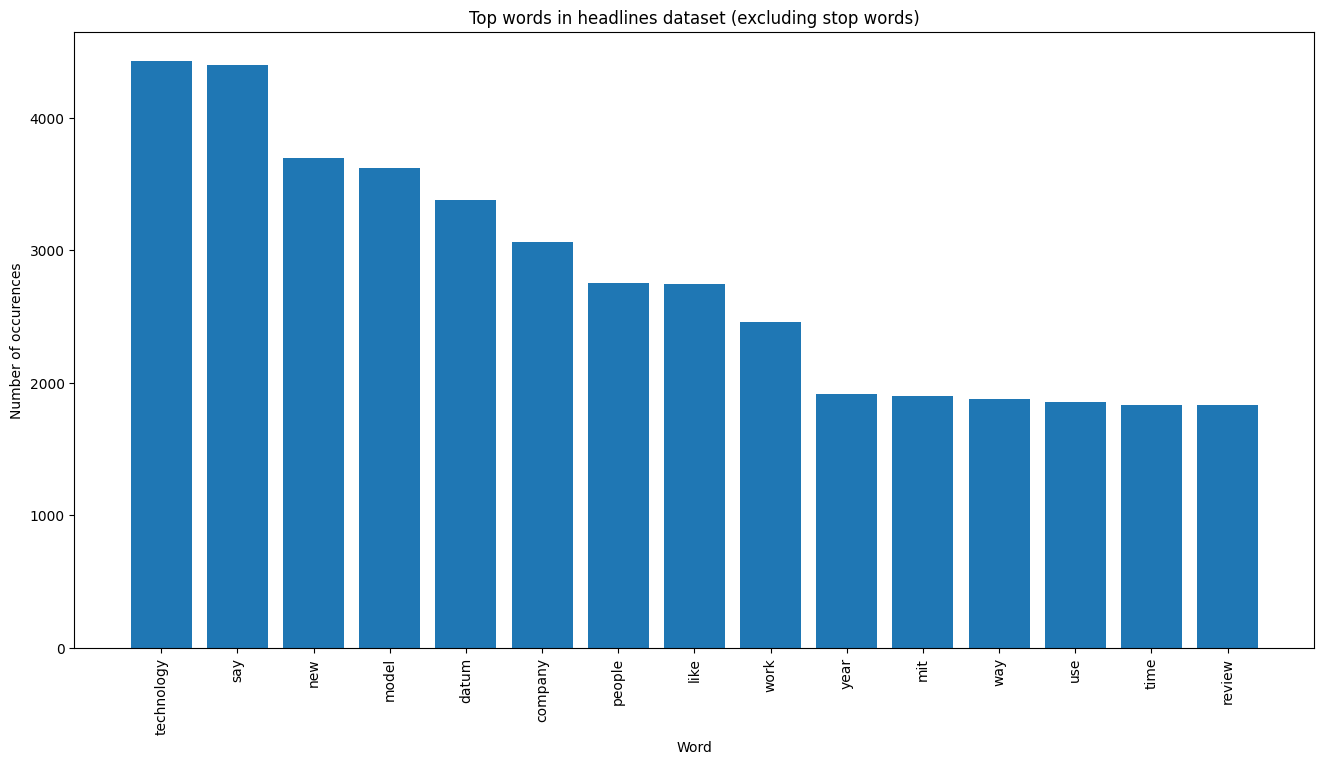

In [22]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [23]:
df.head()

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,203.896104,421.675325,-1,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,276.623377,556.571429,-1,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,141.558442,608.454545,p_2,useful robot need lazy useful robot need lazy ...
3,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"['Marcus Holmström', 'The Gang', 'AI', 'France...",2,#0000ff,338.961039,266.025974,p_11,roblox launch generative build environment sna...
4,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\r\nIntegrating security from code to...,"['TEE', 'Microsoft Security', 'Insights', 'the...",2,#0000ff,349.350649,857.493506,-1,integrate security code cloud sponsored integr...


### Save clean text

In [24]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [ ]:
#df = pd.read_csv('Query_AI_text_clean.csv')

In [ ]:
df.head(3)

### Temperature

In [ ]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

### Term Frequency

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

## UMAP

In [ ]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=3,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

In [ ]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [ ]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)